# AR(1) + GARCH(1,1) Model

This notebook estimates an AR(1) where the residuals follow a GARCH(1,1) model. The results are used to calculate a time-varying (daily) value at risk. 

For learning purposes the code specifies the likelihood function and then calls on the (home brewed) `MLE()` function. For a more automated approach, consider the [ARCHModels.jl](https://github.com/s-broda/ARCHModels.jl) package. You may want to look at the MLE notebook before the current one.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics, LinearAlgebra, Optim

using FiniteDiff: finite_difference_hessian as hessian, finite_difference_jacobian as jacobian

include("jlFiles/MLE.jl")              #function for MLE
include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

## Loading Data

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2]                 #returns for the smallest size portfolio
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(y)) R[1:end-1]]         #regressors, [1, y(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$
y_{t}             =x_{t}^{\prime}b+u_{t} \: \text{ with }\: u_{t}=v_{t}\sigma_{t} \: \text{ and }
$

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

Notice that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is $\sum_{t=1}^{T} \ln L_t$ where

$
\ln L_t=-\frac{1}{2}\ln(2\pi) -\frac{1}{2}\ln\sigma_{t}^{2}- \frac{1}{2}\frac{u_{t}^{2}}{\sigma_{t}^{2}}.
$

The likelihood function of a GARCH(1,1) model is in `garch11LL`.

### A Remark on the Code

For simplicity, the $\sigma_t^2$ is calculated in a loop. As an alternative, consider the `filt()` function from the [DSP.jl](https://github.com/JuliaDSP/DSP.jl) package.

In [4]:
function garch11LL(par,yx)
    
    (y,x) = (yx[:,1],yx[:,2:end])

    (T,k) = (size(x,1),size(x,2))

    b       = par[1:k]             #mean equation, y = x'*b
    (ω,α,β) = par[k+1:k+3]         #GARCH(1,1) equation: 
                                   #σ²(t) = ω + α*u(t-1)^2 + β*σ²(t-1)
    yhat = x*b                                
    u    = y - yhat                #fitted regression residuals
    σ²_0 = var(u)

    σ²    = zeros(typeof(α),T)     #works with ForwardDiff too
    σ²[1] = ω + α*σ²_0 + β*σ²_0
    for t = 2:T                                    
      σ²[t] = ω + α*u[t-1]^2 + β*σ²[t-1]
    end

    LL_t    = -(1/2)*log(2*π) .- (1/2)*log.(σ²) .- (1/2)*(u.^2)./σ²
    LL_t[1] = 0.0               #effectively skip the first observation

    #LL      = sum(LL_t)

    return LL_t, σ², yhat, u

end

garch11LL (generic function with 1 method)

## Try the Likelihood Function

In [5]:
coefNames = ["b₀","b₁","ω","α","β"]
par0      = [mean(y),0,var(y)*0.05,0.05,0.90]         #initial parameter guess

(LLt,) = garch11LL(par0,[y x])                   #testing the log lik

printlnPs("Value of log-likelihood fn at starting guess of the parameters: ",sum(LLt))

Value of log-likelihood fn at starting guess of the parameters:  -9231.913


## Maximize the Likelihood Function

In [7]:
lower = [-Inf,-0.99, 0,0,0]        #upper and lower bounds on the parameters: b0,b1,ω,α,beta
upper = [ Inf, 0.99,10,1,1]

garch11LL_(par,x) = garch11LL(par,x)[1]    #to get a function with just one output as MLE wants
(parHat,std_hess,std_grad,std_sandw) = MLE(garch11LL_,par0,[y x],lower,upper)

printblue("point estimates and standard errors:\n")
xx = [parHat std_hess std_grad std_sandw]
printmat(xx,colNames=["estimate","std (InfoMat)","std (gradients)","std (sandwich)"],rowNames=coefNames,width=14)

point estimates and standard errors:

        estimate std (InfoMat)std (gradients)std (sandwich)
b₀         0.049         0.006         0.006         0.007
b₁         0.256         0.012         0.012         0.013
ω          0.014         0.001         0.001         0.003
α          0.162         0.009         0.005         0.020
β          0.824         0.009         0.005         0.019



# Value at Risk

calculated by assuming conditional (time-varying) normality,

$
\text{VaR} = -(\mu_t - 1.645 \sigma_t),
$

where 
$\mu_t$ are the predictions from the estimated mean equation ($x_t'b$) and $\sigma_t$ from the GARCH(1,1) model.

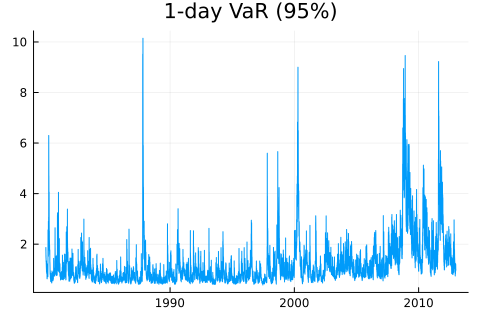

In [8]:
(σ²,μ) = garch11LL(parHat,[y x])[2:3]         #get the fitted values of the σ²- and μ-vectors
VaR95  = -(μ - 1.645*sqrt.(σ²))


xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],VaR95,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "1-day VaR (95%)" )
display(p1)

In [9]:
CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("Coverage ratio for VaR(95%): ",CovRatio)

Coverage ratio for VaR(95%):      0.058


# eGARCH (extra)

This section estimates eGARCH models for 2 return series.

In [10]:
include("jlFiles/Garch.jl")

DccParTrans (generic function with 1 method)

## Load Data

In [11]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2:end]             #returns for 10 different portfolios
xx  = nothing

R9 = R[2:end,9]                         #returns, 2nd largest firms
x9 = [ones(size(R9)) R[1:end-1,9]]      #regressors, [1, R1(t-1)]

R10 = R[2:end,10]                         #returns, largest firms
x10 = [ones(size(R10)) R[1:end-1,10]]     #regressors, [1, R10(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

## Estimate eGARCH(1,1) models

for each of the two return series. Also, calculate the standardized residuals as 
$v_t = u_t/\sigma_t$

In [12]:
par0 = [mean(R9),0,var(R9)*0.05,0.05,0.90,0]   #initial parameter guess: b0,b1,ω,α,β,γ

lower = [-Inf,-0.99,-Inf,-Inf,0,-Inf]              #upper and lower bounds on the parameters
upper = [ Inf, 0.99, Inf, Inf,1, Inf]

egarch11LL_(par,yx) = egarch11LL(par,yx)[1]              #to get a function with just one output
parHat, = MLE(egarch11LL_,par0,[R9 x9],lower,upper)

(_,σ²_9,_,u) = egarch11LL(parHat,[R9 x9])
v9 = u./sqrt.(σ²_9)                       #standardized residuals (used below)

printblue("eGARCH(1,1), parameter estimates for R9:\n")
coefNames = ["b₀","b₁","ω","α","β","γ"]
printmat(parHat,colNames=["coef"],rowNames=coefNames)

eGARCH(1,1), parameter estimates for R9:

        coef
b₀     0.042
b₁     0.100
ω     -0.116
α      0.147
β      0.980
γ     -0.088



In [13]:
parHat, = MLE(egarch11LL_,par0,[R10 x10],lower,upper)

(_,σ²_10,_,u) = egarch11LL(parHat,[R10 x10])
v10 = u./sqrt.(σ²_10)

printblue("eGARCH(1,1), parameter estimates for R10:\n")
printmat(parHat,colNames=["coef"],rowNames=coefNames)

eGARCH(1,1), parameter estimates for R10:

        coef
b₀     0.041
b₁     0.001
ω     -0.100
α      0.130
β      0.982
γ     -0.085



# DCC (extra)

This section estimates a DCC model from the two series of standardized residuals (from the eGARCH estimation above).

To impose the necessary restrictions, we estimate `(a,b)` but they imply the following `(α,β)` via the `DccParTrans()` function:

$
\alpha = e^a/(1+e^a+e^b)
$

$
\beta = e^b/(1+e^a+e^b)
$

## A Note on the Code

The `DccLL()` function calculates the ($T$-vector of) log-likelihood functions values. It takes the transformed parameters (see above) and a 3-vector `data` as inputs. The latter is a vector of arrays, where `v = data[1], σ² = data[2], Qbar = data[3]`.

In [14]:
par0 = [0.2,1.5]
(α,β) = DccParTrans(par0)            #we estimate (a,b), but they imply (α,β)

println("Initial guess of parameters")
printmat([α,β],colNames=["coef"],rowNames=["α","β"])

v   = [v9 v10]
σ²  = [σ²_9 σ²_10]
Qbar = cov(v)
data = [v,σ²,Qbar]             #vector of arrays, unpacked inside DccLL  

LL_t, = DccLL(par0,data)       #testing the log likelihood fn
println("Testing the log likelihood fn: ",sum(LL_t))

Initial guess of parameters
       coef
α     0.182
β     0.669

Testing the log likelihood fn: -13944.615139051915


In [15]:
Sol = optimize(par->-sum(DccLL(par,data)[1]),par0)    #estimate (a,b)
parHat = Optim.minimizer(Sol)
(α,β) = DccParTrans(parHat)                                #(a,b) -> (α,beta) 

println("Estimated parameters")
printmat([α,β],colNames=["coef"],rowNames=["α","β"])

Estimated parameters
       coef
α     0.024
β     0.967



In [16]:
"""
    CovToCor(covMat)

Compute correlation matrix from covariance matrix.

"""
function CovToCor(covMat)
  d      = diag(covMat)            #variances
  corMat = covMat./sqrt.(d*d')
  return corMat
end

CovToCor

In [17]:
(_,Σ) = DccLL(parHat,data)     #nxnxT covariance arrays
T = size(Σ,3)

ρ = fill(NaN,T)                #the fitted correlations
for t = 1:T
    ρ[t] = CovToCor(Σ[:,:,t])[1,2]
end

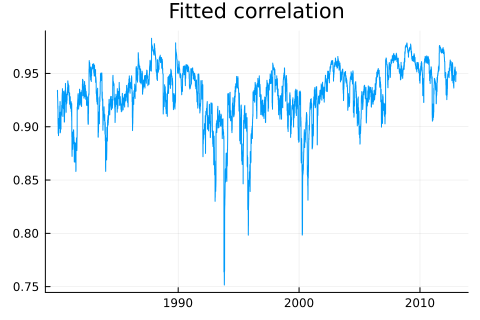

In [18]:
p1 = plot( dN[2:end],ρ,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "Fitted correlation" )
display(p1)